# 第4回 回帰その2: 過学習と正則化

いつものように右上の「Remix」ボタンを押して自分用の複製を作成すれば、各セルを「Shift+Enter」で実行しながら読むことができます

必要なパッケージを読み込みます

In [1]:
using Plots, CSV, Statistics, LinearAlgebra, Random

# 過学習

In [1]:
# テストデータの作成
N = 50
#x = range(0.0, stop=1.0, length=N)
x = 2.0.*(rand(N).-0.5)
x = sort(x)
X = [x x.^2 x.^3 x.^4 x.^5 x.^6 x.^7 x.^8 x.^9 x.^10 x.^11 x.^12 x.^13]
w_true = [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
y = X * w_true .+ 0.2 * randn(N);

In [1]:
# 今回のデータは全て標準化を行うことにする。したがって、切片はゼロ
# 標準化を行う関数を定義する
function centerize!(y, X)
  y_mean = mean(y)
  y .= y .- y_mean
  X_mean = mean(X, dims=1)
  N = Float64(length(y))
  X .= X .- X_mean
  X_scale = sqrt.(N ./ sum(X.^2, dims=1))
  X .= X .* X_scale
  return y_mean, X_mean, X_scale
end

centerize!

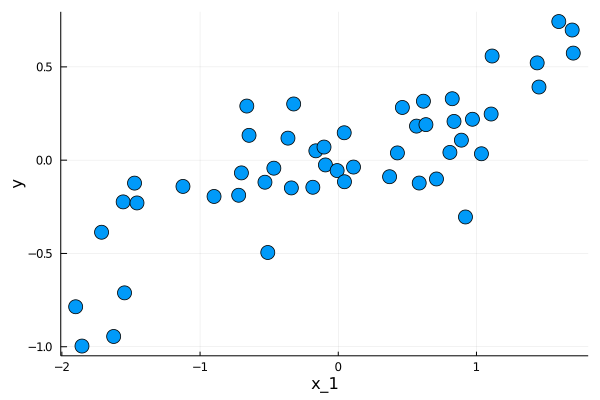

In [1]:
y_mean, X_mean, X_scale = centerize!(y, X)
scatter(X[:, 1], y, xlabel="x_1", ylabel="y", ms=8, legend=false)

In [1]:
#擬似逆行列を使った重回帰の計算 (前回と同じ関数)
function solve_multiple_regression(X, y)
	w = inv(X' * X) * X' * y # 本当はpinv関数や特異値分解(SVD)を用いるほうが安定に計算できる
  return w
end

solve_multiple_regression

In [1]:
w = solve_multiple_regression(X, y)

13-element Array{Float64,1}:
   -0.161433
    0.656235
    5.58771
   -7.97216
  -39.164
   34.7094
  123.784
  -66.8668
 -193.982
   58.6438
  149.102
  -19.1858
  -44.858

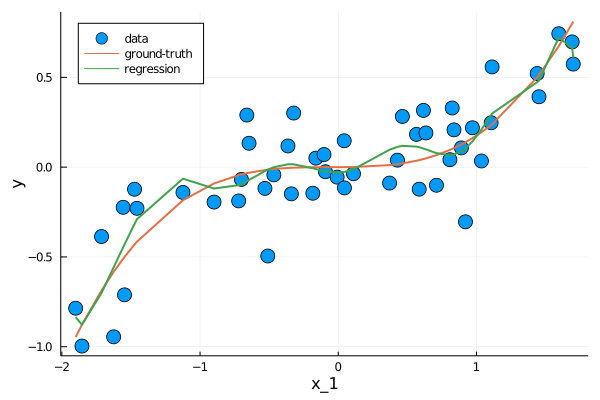

In [1]:
scatter(X[:, 1], y, xlabel="x_1", ylabel="y", ms=8, label="data")
plot!(X[:, 1], ((X[:, 1].+X_mean[:,1])./X_scale[1]).^3, lw=2, label="ground-truth")
plot!(X[:, 1], X*w, label="regression", lw=2, legend=:topleft)

# 交差検証 (Cross-validation)

In [1]:
# K-foldの交差検証を行う関数を定義する
# 交差検証エラーを返すようにする
# kはk-foldのk
# solverは重回帰を解く関数か、Ridge回帰を解く関数か、Lasso回帰を解く関数かを選べる。デフォルトは重回帰。
function compute_cross_validation_error(k, X, y; solver=solve_multiple_regression)
	N = size(X, 1)
  cv_error = zeros(Float64, k)
  index_mod = mod.(Random.randperm(N), k)
  for j = 1:k
    index_train = index_mod .!= j-1
    index_test  = index_mod .== j-1
    X_train =  X[index_train, :]
    y_train =  y[index_train]
    X_test  =  X[index_test, :]
    y_test  =  y[index_test]
	  w = solver(X_train, y_train)
    y_predict = X_test*w;
    cv_error[j] = sum((y_test .- y_predict).^2)
  end
  return mean(cv_error)
end

compute_cross_validation_error

In [1]:
# 交差検証エラーを求める
k = 10
compute_cross_validation_error(k, X, y)

0.435646

In [1]:
# 様々な次数のモデルの交差検証エラーを求める
k = 10
nth_order_max = 10
cv_error = zeros(Float64, nth_order_max)
for n = 2:nth_order_max
  cv_error[n] = compute_cross_validation_error(k, X[:, 1:n], y)
end

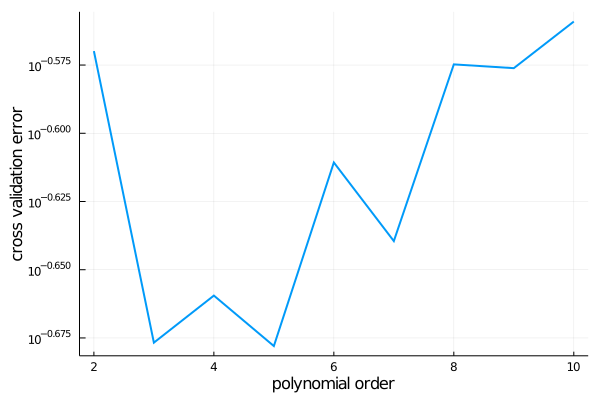

In [1]:
plot(2:nth_order_max, cv_error[2:end], yaxis=:log, xlabel="polynomial order", ylabel="cross validation error", legend=:none, lw=2)

# Ridge回帰

In [1]:
#Ridge回帰を求める関数を定義する
function solve_ridge(X, y, lambda)
	w = inv(X' * X + lambda * I) * X' * y
  return w
end

solve_ridge

In [1]:
w = solve_ridge(X, y, 0.1)

13-element Array{Float64,1}:
  0.091349
  0.0174569
  0.00157842
  0.00169018
  0.164496
 -0.0265181
  0.184993
 -0.0364949
  0.0967291
 -0.0121019
 -0.0378446
  0.0270006
 -0.189961

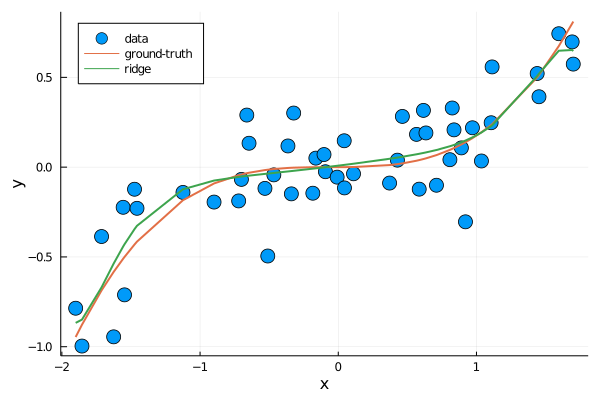

In [1]:
scatter(X[:, 1], y, xlabel="x", ylabel="y", ms=8, label="data")
plot!(X[:, 1], ((X[:, 1].+X_mean[:,1])./X_scale[1]).^3, lw=2, label="ground-truth")
plot!(X[:, 1], X*w, label="ridge", lw=2, legend=:topleft)

# Lasso回帰

In [1]:
#Lasso回帰を求める関数を定義する
function funcS(x, lambda)
    return sign(x) * max(abs(x) - lambda, 0.0)
end

function solve_lasso(X, y, lambda)
  condition = 1e-5
  iter_max = 10000
  nframe = size(X, 1)
  nfeature = size(X, 2)
  Xty = X' * y
  XtX = X' * X

  beta = similar(y, nfeature)
  beta_old = similar(y, nfeature)
  beta .= one(y[1])
  beta_old .= beta
  rhs = similar(y, nfeature)
  max_diff = 100.0
  cnt = 1
  while max_diff > condition
      cnt += 1
      for j = 1:nfeature
          rhs1 = Xty[j]
          rhs2 =  sum(XtX[j, :] .* beta)
          rhs3 = nframe * beta[j]
          rhs = rhs1 - rhs2 + rhs3
          beta[j] = funcS(rhs/nframe, lambda)
      end
      max_diff = maximum(abs.(beta .- beta_old))
      beta_old .= beta
      if cnt > iter_max
          break
      end
  end

  #println("[ Cycle Count = ", cnt, " ]")
  #println("[ Complete Condition ]")
  #println("  Max Differ = ", max_diff)
  #println("\n")
  return beta
end

solve_lasso

In [1]:
w = solve_lasso(X, y, 0.05)

13-element Array{Float64,1}:
  0.0129185
 -0.0
  0.250041
 -0.0
  0.0
 -0.0
  0.0
 -0.0
  0.0
 -0.0
  0.0
 -0.0
  0.0

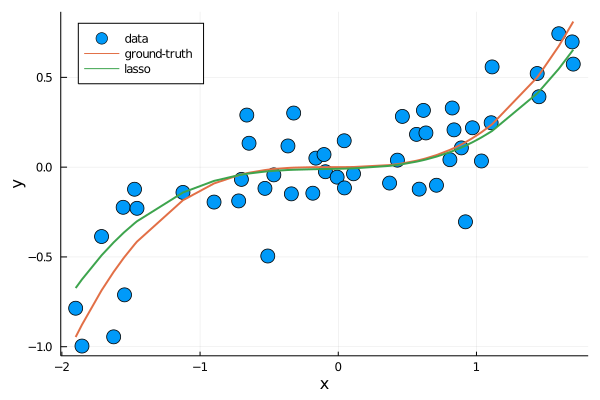

In [1]:
scatter(X[:, 1], y, xlabel="x", ylabel="y", ms=8, label="data")
plot!(X[:, 1], ((X[:, 1].+X_mean[:,1])./X_scale[1]).^3, lw=2, label="ground-truth")
plot!(X[:, 1], X*w, label="lasso", lw=2, legend=:topleft)

In [1]:
# 様々なlambdaの交差検証エラーを求める
k = 10
lambda = 10 .^ (range(-5, stop=-1, length=30))
cv_error = zeros(Float64, length(lambda))
for i in 1:length(lambda)
  cv_error[i] = compute_cross_validation_error(k, X, y, 
    solver = (X, y) -> solve_lasso(X, y, lambda[i]))
end

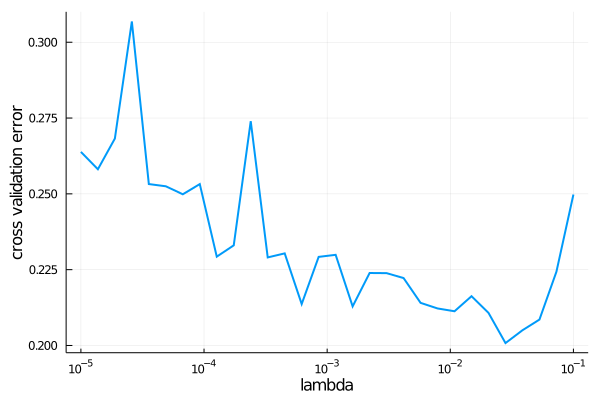

In [1]:
plot(lambda, cv_error, xaxis=:log, xlabel="lambda", ylabel="cross validation error", lw=2, legend=:none)

# 小レポート：boston housing への応用

前回と同じboston housingデータへLasso回帰を応用してみましょう。住宅価格(MEDV)に対して、Lasso回帰で選択される目的変数は何でしょうか？

[boston.csv](https://nextjournal.com/data/QmWXcYso6G9WxJMjF38E3gNshXYrD1FnNueQa7AyWGnn2f?content-type=text/csv&node-id=bdf80dd3-6413-46e9-8853-815d044c3168&filename=boston.csv&node-kind=file)

データを読み込んで出力(目的変数)yへ住宅価格(MEDV)、説明変数へ1〜13列目を代入します

In [1]:
boston = CSV.read("/.nextjournal/data-named/QmWXcYso6G9WxJMjF38E3gNshXYrD1FnNueQa7AyWGnn2f/boston.csv")

もう一度各列の意味を確認します

 1. CRIM 地域ごとの一人当たりの犯罪率 (町ごとの一人あたり) (説明変数)
 2. ZN 25,000 平方フィート以上の住宅区画の割合 (説明変数)
 3. INDUS	小売業以外の商業が占める土地面積の割合 (説明変数)
 4. CHAS チャールズ川沿いかどうかの変数（川沿い1、それ以外0、説明変数）
 5. NOX 一酸化窒素濃度（ppgm単位、説明変数）
 6. RM 1戸あたりの部屋数 (説明変数)
 7. AGE 1940年以前に建設された物件の割合 (説明変数)
 8. DIS 地域から5つの雇用施設までの重み付き距離 (説明変数)
 9. RAD 高速道路へのアクセスしやすさ (説明変数)
10. TAX 10,000ドルあたりの固定資産税の割合 (説明変数)
11. PTRATIO 生徒と教師の比率 (説明変数)
12. B	地域における黒人の割合 (説明変数)
13. LSTAT	地域における低所得者の割合 (説明変数) 
14. MEDV 住宅価格の中央地 (1000ドル単位) **(目的変数)**

In [1]:
#演算しやすいように浮動小数点のFloat64のVector型(=1次元Array型)へ変換する
y = Vector{Float64}(boston.MEDV)
#演算しやすいように浮動小数点のFloat64のMatrfix型(=2次元Array型)へ変換する
X = Matrix{Float64}(boston[:, 1:13])
N = length(y)

506

In [1]:
#標準化
centerize!(y, X)

(22.5328, [3.61352 11.3636 … 356.674 12.6531], [0.116373 0.0429196 … 0.0109644 0.140174])

In [1]:
# 小レポート課題

# Lasso回帰(solve_lasso()を使う)としてlambda=1.0としてwを求めて以下の問いに答えてください。

# 設問1
# どの説明変数が非ゼロとして選択されましたか？最も傾きが大きいものと、小さいものを選び、なぜそれが選ばれたか考察を述べてください。

# 設問2
# 前回の重回帰の時に傾きが最も小さかったNOXはどうなりましたか？そうなった理由の考察を述べてください。

w = solve_lasso(X, y, 1.0)

13-element Array{Float64,1}:
 -0.0
  0.0
 -0.0
  0.0
 -0.0
  2.71311
 -0.0
 -0.0
 -0.0
 -0.0
 -1.3435
  0.180798
 -3.54361

In [1]:
# wを整理してプリントする
for i = 1:13
  println("w_$(i), $(names(boston)[i]): $(w[i])")
end

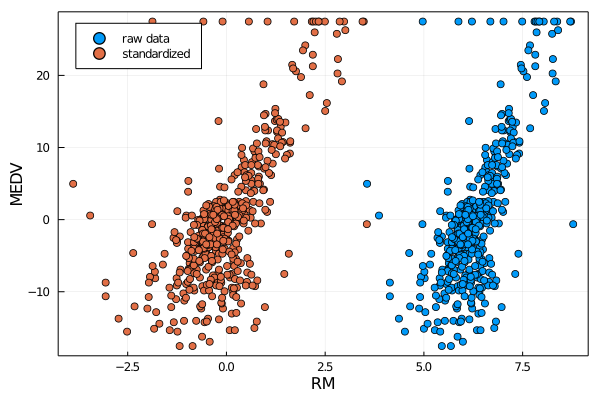

In [1]:
scatter(boston.RM, y, label="raw data")
scatter!(X[:, 6], y, xlabel="RM", ylabel="MEDV", label="standardized", framestyle = :box, legend=:topleft)

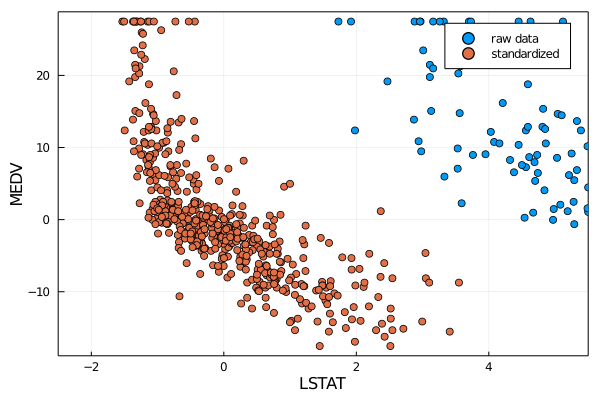

In [1]:
scatter(boston.LSTAT, y, label="raw data")
scatter!(X[:, 13], y, xlabel="LSTAT", ylabel="MEDV", label="standardized", framestyle = :box, legend=:topright, xlim=(-2.5, 5.5))

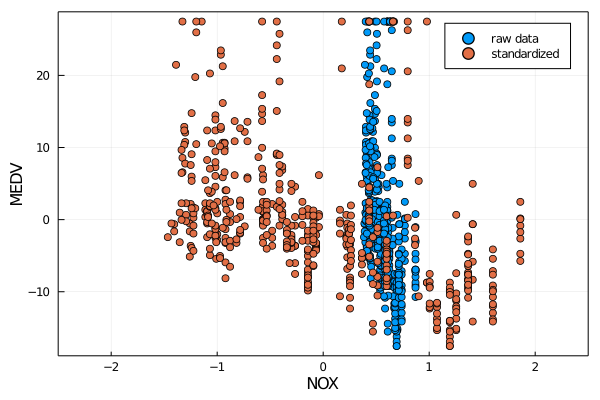

In [1]:
scatter(boston.NOX, y, label="raw data")
scatter!(X[:, 5], y, xlabel="NOX", ylabel="MEDV", label="standardized", framestyle = :box, legend=:topright, xlim=(-2.5, 2.5))